               Price     TotalArea       NrRooms       Balcony         Floor  \
count   16394.000000  16394.000000  16394.000000  16394.000000  16394.000000   
mean    70172.082530     67.011346      2.117421      1.194217      5.227278   
std     31177.912393     56.419444      0.809304      0.595619      3.434365   
min     25000.000000      5.000000      1.000000      0.000000      0.000000   
25%     47900.000000     50.000000      2.000000      1.000000      3.000000   
50%     63700.000000     65.000000      2.000000      1.000000      5.000000   
75%     85000.000000     77.000000      3.000000      1.000000      7.000000   
max    200000.000000   6485.000000      5.000000      3.000000     21.000000   

       NumberOfFloors           Lon           Lat   UpdateMonth  UpdateYear  
count    16394.000000  16394.000000  16394.000000  16394.000000     16394.0  
mean         9.304502     28.808497     47.043700      4.126876      2023.0  
std          3.727462      0.180240      0.16

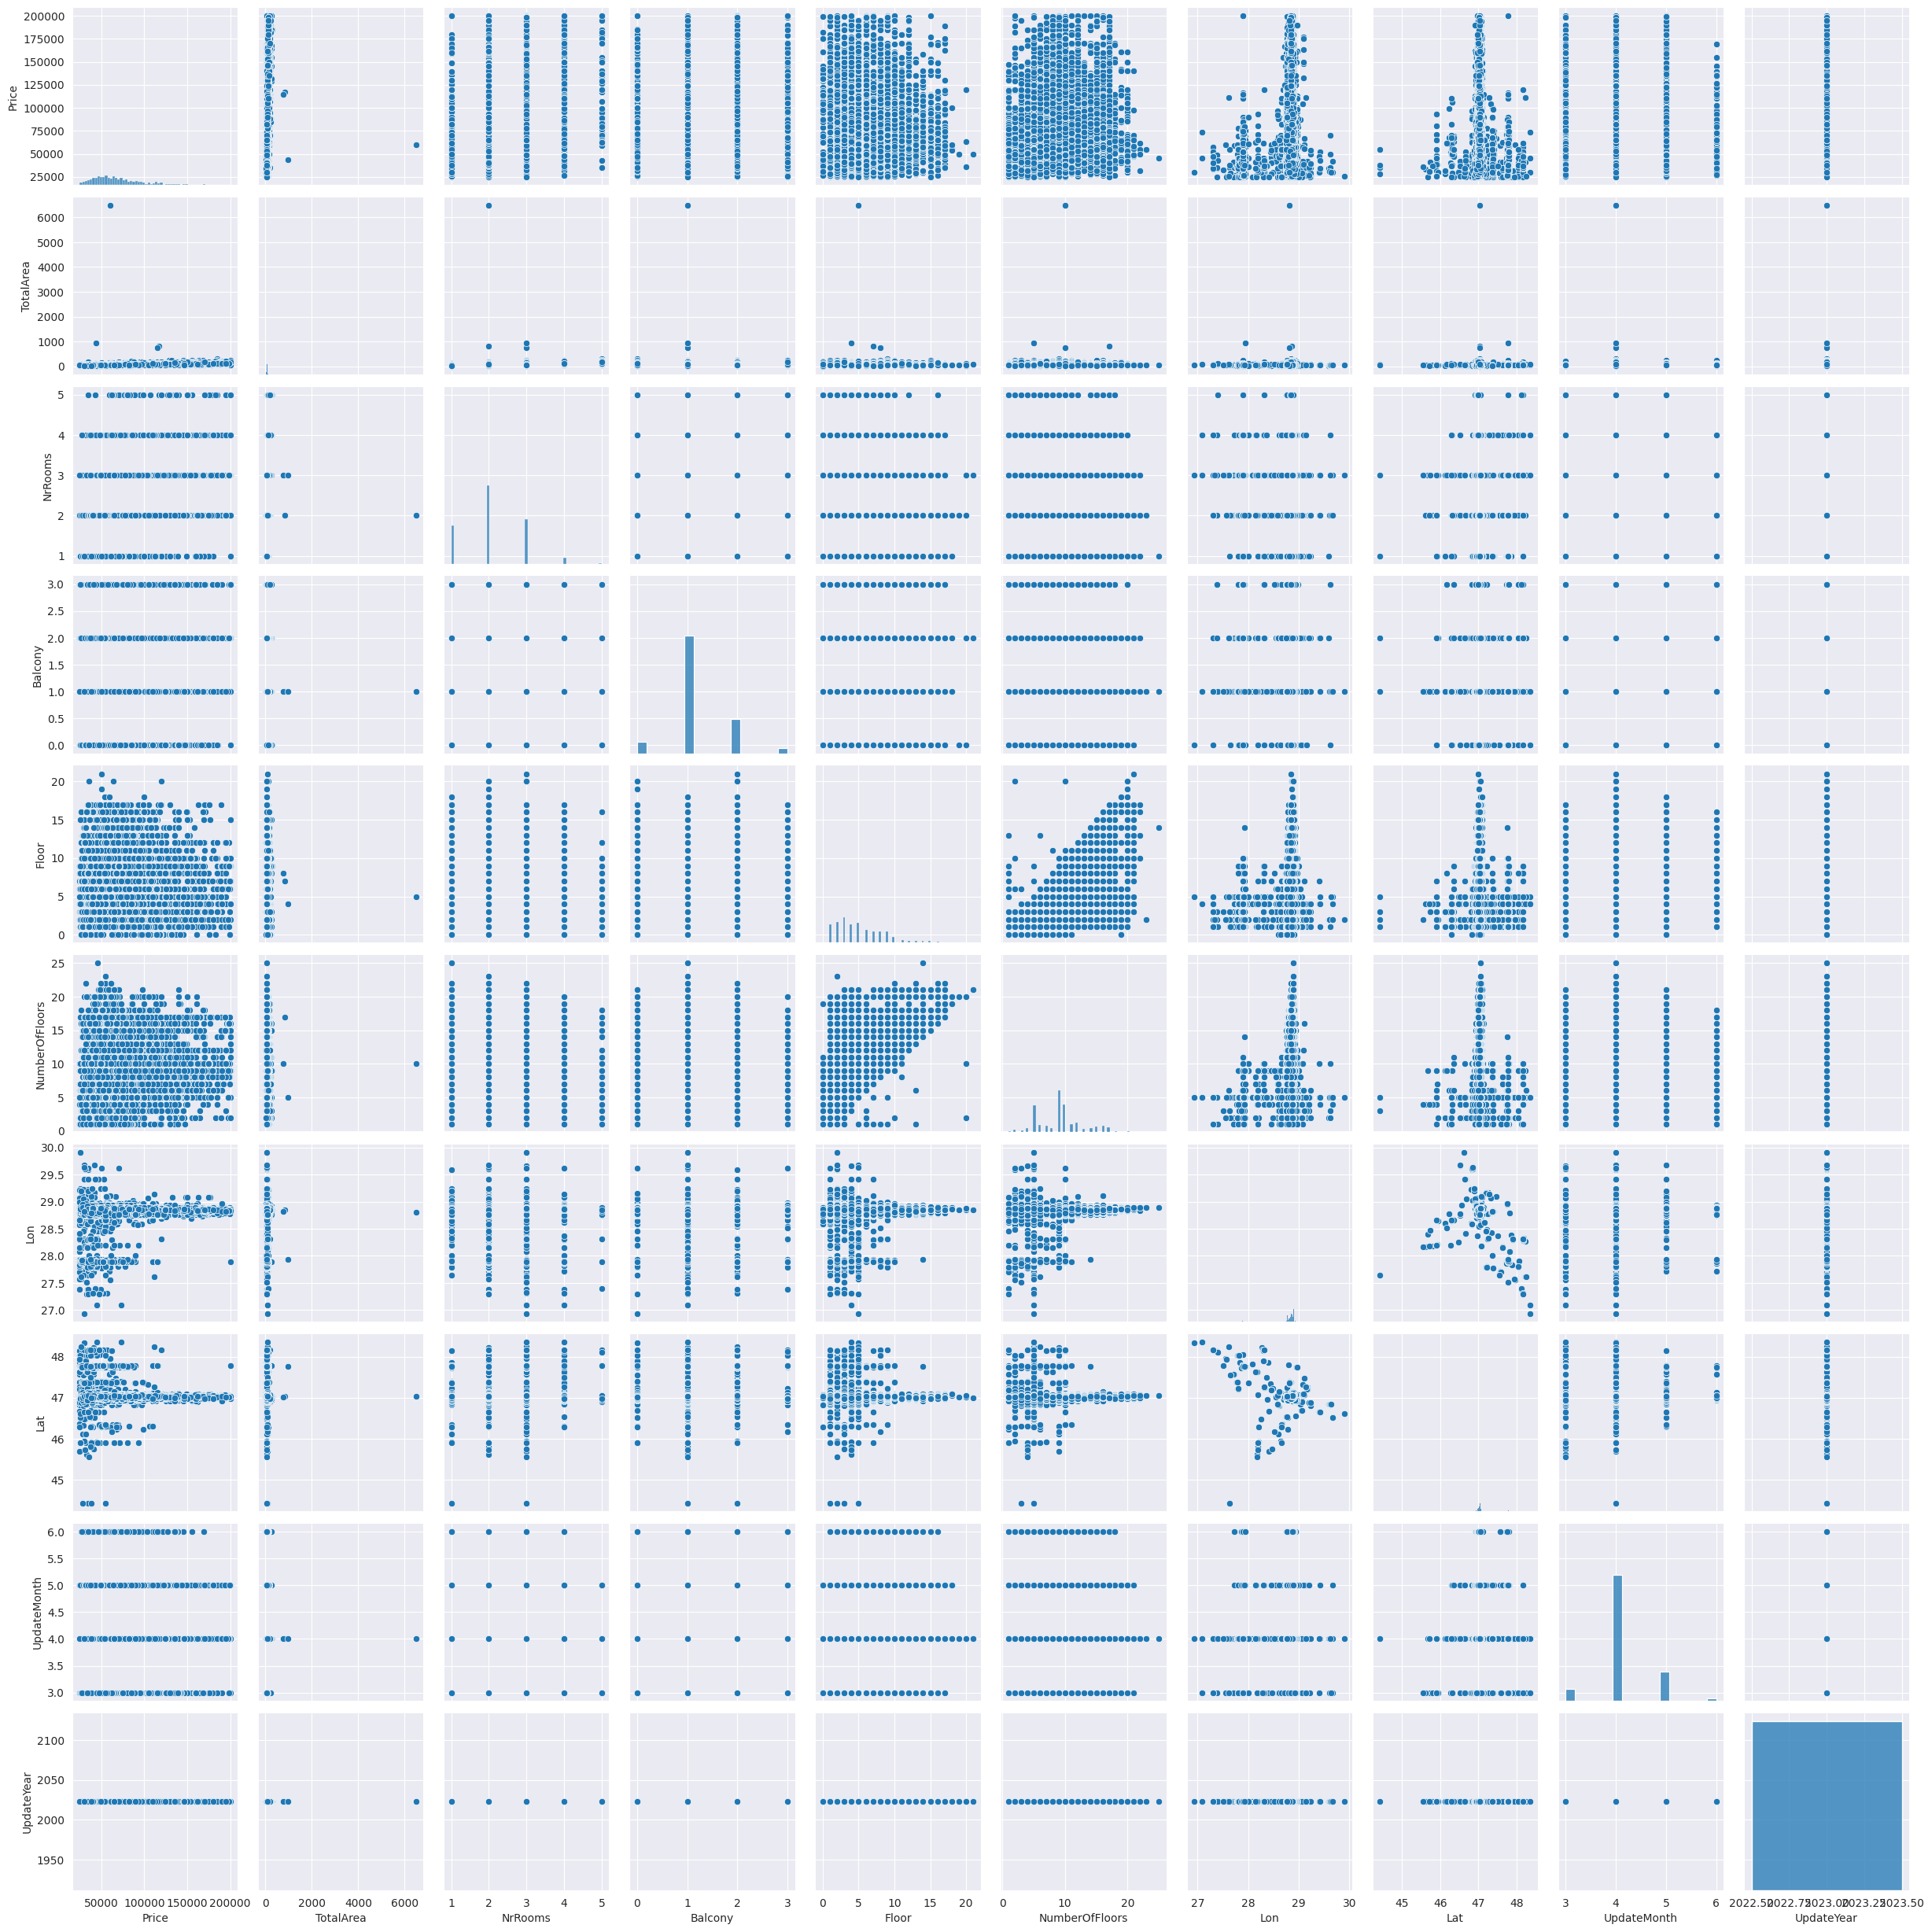

/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_15191/2833277557.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['GeoCluster'] = kmeans_geo.fit_predict(scaled_data_geo)


MSE: 159630160.29714438, RMSE: 12634.482984956068, R2: 0.8333073715734252
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_pa

Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Best R2: 0.8332760375713959


In [3]:
# House Price Prediction with Clustering and Filtering

# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Data Loading
# Load the dataset. Replace the file path with your actual file path.
file_path = 'preprocessed.json'
df = pd.read_json(file_path)

# Data Cleaning
# Convert 'UpdatedAt' to datetime format
df['UpdatedAt'] = pd.to_datetime(df['UpdatedAt'])

# Feature Engineering
# Extract month and year from 'UpdatedAt'
df['UpdateMonth'] = df['UpdatedAt'].dt.month
df['UpdateYear'] = df['UpdatedAt'].dt.year

# Apply Filtering Conditions
# Limit the price between 25000 and 200000 and remove properties with 0 rooms
filtered_df = df[(df['Price'] >= 25000) & (df['Price'] <= 200000) & (df['NrRooms'] > 0)]

# Extended Exploratory Data Analysis (EDA)
# Summary statistics
print(filtered_df.describe())

# Correlation matrix
corr_matrix = filtered_df.corr(numeric_only=True)
print(corr_matrix)

# Heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Boxplots for categorical features
for feature in ['NrRooms', 'Balcony', 'Floor', 'NumberOfFloors', 'UpdateMonth', 'UpdateYear', 'GeoCluster']:
    sns.boxplot(x=feature, y='Price', data=filtered_df)
    plt.title(f'Price vs {feature}')
    plt.show()

# Clustering Based on 'Lat' and 'Lon'
# Standardize the features for clustering
clustering_features_geo = ['Lat', 'Lon']
scaler_geo = StandardScaler()
scaled_data_geo = scaler_geo.fit_transform(filtered_df[clustering_features_geo])

# Perform KMeans clustering based on 'Lat' and 'Lon'
kmeans_geo = KMeans(n_clusters=5, random_state=42)
filtered_df['GeoCluster'] = kmeans_geo.fit_predict(scaled_data_geo)

# Visualizing the Clusters on a Scatter Plot
plt.scatter(filtered_df['Lat'], filtered_df['Lon'], c=filtered_df['GeoCluster'], cmap='rainbow')
plt.title('Clusters Based on Lat and Lon')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar().set_label('Cluster ID')
plt.show()

# Model Building
# Train a Random Forest model
features = ['TotalArea', 'NrRooms', 'Balcony', 'Floor', 'NumberOfFloors','Lat', 'Lon',  'UpdateMonth', 'UpdateYear', 'GeoCluster']
target = 'Price'
X_train, X_test, y_train, y_test = train_test_split(filtered_df[features], filtered_df[target], test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Evaluation
# Evaluate the model
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, RMSE: {rmse}, R2: {r2}')

# Hyperparameter Tuning
# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
print(f'Best Params: {best_params}, Best R2: {r2_best}')

In [7]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

# Define the base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('ridge', Ridge(alpha=1.0))
]

# Initialize the stacking regressor with a Random Forest as the final estimator
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=RandomForestRegressor(n_estimators=50, random_state=42))

# Fit the model to the training data
stacking_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stack = stacking_regressor.predict(X_test)

# Calculate R-squared value
r2_stack = r2_score(y_test, y_pred_stack)

print(f'Stacking Regressor R2: {r2_stack}')


Stacking Regressor R2: 0.8120219172411309


In [10]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score

# Define CatBoost and LightGBM models with some initial hyperparameters
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

# Define the base models
base_models_advanced = [
    ('rf_tuned', RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2, random_state=42)),
    ('gb_tuned', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)),
    ('catboost', catboost_model),
    ('lgbm', lgbm_model),
    ('ridge', Ridge(alpha=1.0))
]

# Initialize the advanced stacking regressor with XGBoost as the final estimator
final_estimator_advanced = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
stacking_regressor_advanced = StackingRegressor(estimators=base_models_advanced, final_estimator=final_estimator_advanced)

# Fit the model to the training data
stacking_regressor_advanced.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stack_advanced = stacking_regressor_advanced.predict(X_test)

# Calculate R-squared value
r2_stack_advanced = r2_score(y_test, y_pred_stack_advanced)

print(f'Advanced Stacking Regressor with CatBoost and LightGBM R2: {r2_stack_advanced}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 13115, number of used features: 9
[LightGBM] [Info] Start training from score 70259.644148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 10492, number of used features: 9
[LightGBM] [Info] Start training from score 70132.684426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

               Price     TotalArea       NrRooms       Balcony         Floor  \
count   16394.000000  16394.000000  16394.000000  16394.000000  16394.000000   
mean    70172.082530     67.011346      2.117421      1.194217      5.227278   
std     31177.912393     56.419444      0.809304      0.595619      3.434365   
min     25000.000000      5.000000      1.000000      0.000000      0.000000   
25%     47900.000000     50.000000      2.000000      1.000000      3.000000   
50%     63700.000000     65.000000      2.000000      1.000000      5.000000   
75%     85000.000000     77.000000      3.000000      1.000000      7.000000   
max    200000.000000   6485.000000      5.000000      3.000000     21.000000   

       NumberOfFloors           Lon           Lat  
count    16394.000000  16394.000000  16394.000000  
mean         9.304502     28.808497     47.043700  
std          3.727462      0.180240      0.162357  
min          1.000000     26.933880     44.426207  
25%          6.0000

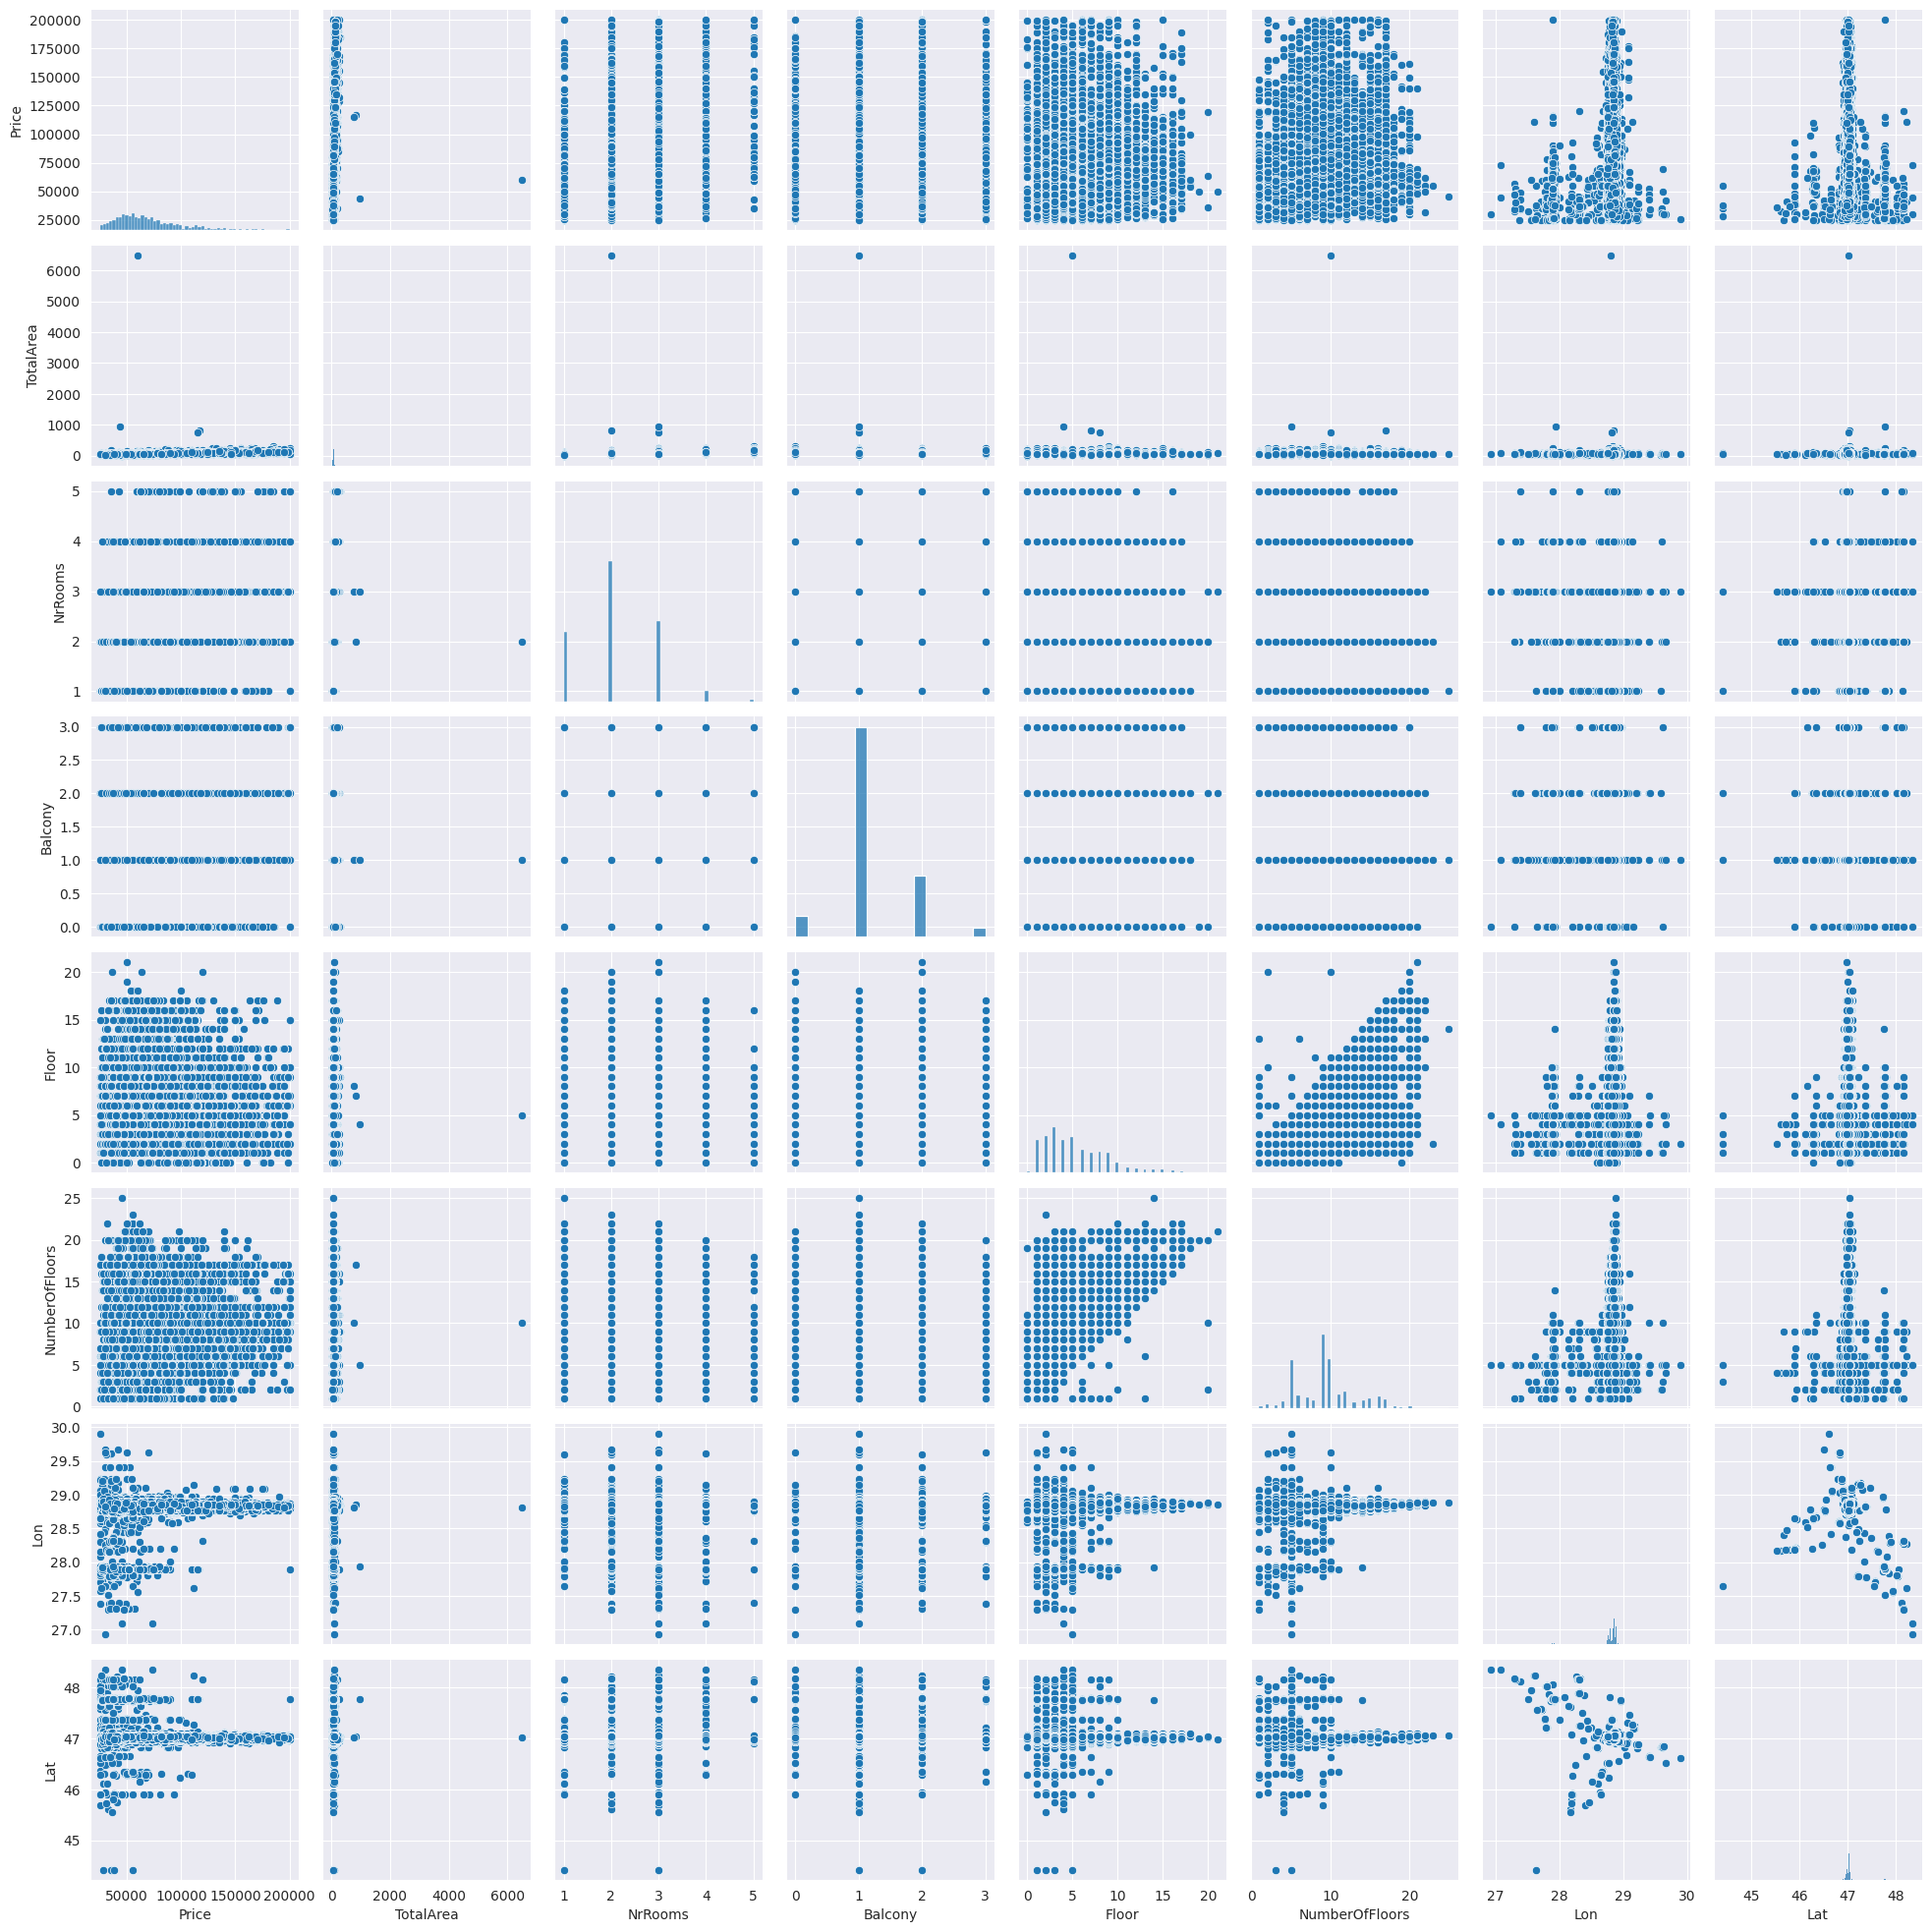

/home/stefan/PycharmProjects/sad/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_15191/3554546071.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['GeoCluster'] = kmeans_geo.fit_predict(scaled_data_geo)


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto

In [ ]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data Loading
file_path = 'preprocessed.json'
df = pd.read_json(file_path)

# Apply Filtering Conditions
filtered_df = df[(df['Price'] >= 25000) & (df['Price'] <= 200000) & (df['NrRooms'] > 0)]

# Exploratory Data Analysis (EDA)
print(filtered_df.describe())
print(filtered_df.corr(numeric_only=True))

# Visualizations
sns.pairplot(filtered_df)
plt.show()

# Clustering Based on 'Lat' and 'Lon'
clustering_features_geo = ['Lat', 'Lon']
scaler_geo = StandardScaler()
scaled_data_geo = scaler_geo.fit_transform(filtered_df[clustering_features_geo])
kmeans_geo = KMeans(n_clusters=5, random_state=42)
filtered_df['GeoCluster'] = kmeans_geo.fit_predict(scaled_data_geo)

# One-Hot Encoding for 'Condition'
s = (filtered_df.dtypes == 'object')
object_cols = list(s[s].index)
OH_encoder = OneHotEncoder(sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(filtered_df[object_cols]))
OH_cols.index = filtered_df.index
OH_cols.columns = [name.replace(' ', '_') for name in OH_encoder.get_feature_names_out()]
filtered_df_final = filtered_df.drop(object_cols, axis=1)
filtered_df_final = pd.concat([filtered_df_final, OH_cols], axis=1)

# Model Building
features = ['TotalArea', 'NrRooms', 'Balcony', 'Floor', 'NumberOfFloors', 'Lon', 'Lat', 'GeoCluster'] + list(OH_cols.columns)
target = 'Price'
X_train, X_test, y_train, y_test = train_test_split(filtered_df_final[features], filtered_df_final[target], test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Evaluation
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, RMSE: {rmse}, R2: {r2}')

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
print(f'Best Params: {best_params}, Best R2: {r2_best}')
